In [1]:
%reload_ext autoreload
# for auto reloading modules without kernel restart
# If this does not work to import custom modules, then restart kernel

In [2]:
# increase default window size for notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

C:\Users\s.kaiser\AppData\Local\Temp\ipykernel_21040\696421802.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import timeit
from datetime import timedelta
from dataclasses import dataclass       # C like structure
import glob                             # finds all the pathnames matching specified pattern
import datetime as dt
import random
!python --version
print('pandas version: ' + pd.__version__)
print('numpy version: ' + np.__version__)

Python 3.9.7
pandas version: 1.4.2
numpy version: 1.21.5


In [5]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

imported custom_plot.py
data_clean imported
data_preprocess imported


In [5]:
!pip install pytorch-forecasting

  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=f819d65caa95f054d1f4341ae2c5479c27a5e7b942504235de0a9d40465214dc
  Stored in directory: c:\users\s.kaiser\appdata\local\pip\cache\wheels\0c\09\9e\49e21a6840ef7955b06d47394afef0058f0378c0914e48b8b8
Successfully built pyperclip


In [6]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [7]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules')) 

In [8]:
import sys, os
cwd = sys.path[0]
sys.path.append(os.path.join(cwd, 'my_modules'))                # sys.path[0] is dir of the ipynb file
import custom_plot
import data_clean
import data_preprocess
import constants

In [9]:
# read data
import pickle
dir_path = os.path.join(cwd, 'csv')
src_path = os.path.join(dir_path, 'li_ts_valid_cycles_with_cellID.pkl')

with open(src_path, 'rb') as f:
    li_ts_cycles = pickle.load(f)

In [10]:
print(len(li_ts_cycles))
print(type(li_ts_cycles[36]))

626
<class 'pandas.core.frame.DataFrame'>


## Stationarity test

link: https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/

A Time series is staionary if:
1. Mean is constant
2. Variance is constant
3. No seasonality/periodicity

**WHY**: Passing stationarity test is important for applyng VAR (Vector Autoregression) model or ARIMA (Autoregressive integrated moving average) model. Also, stationary time series will more often give us a better set of predictions.

**How?** Univariate: Augmented Dicky-Fuller test, Multivariate: Johansen's test

[394, 430, 41, 265]


<IPython.core.display.Javascript object>


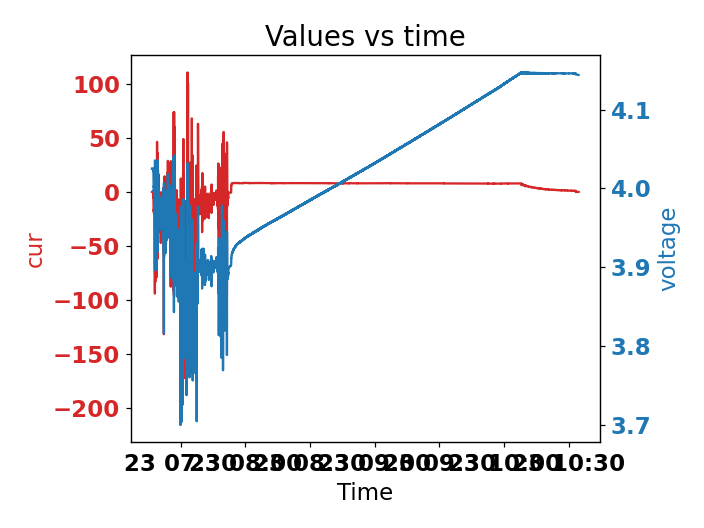

<IPython.core.display.Javascript object>


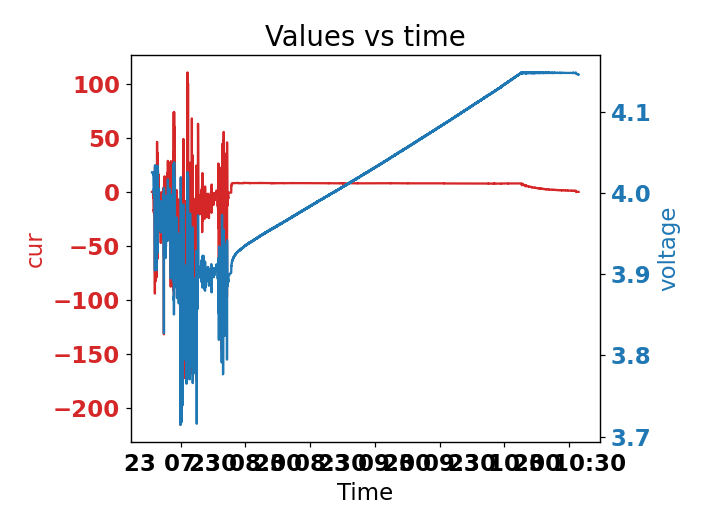

<IPython.core.display.Javascript object>


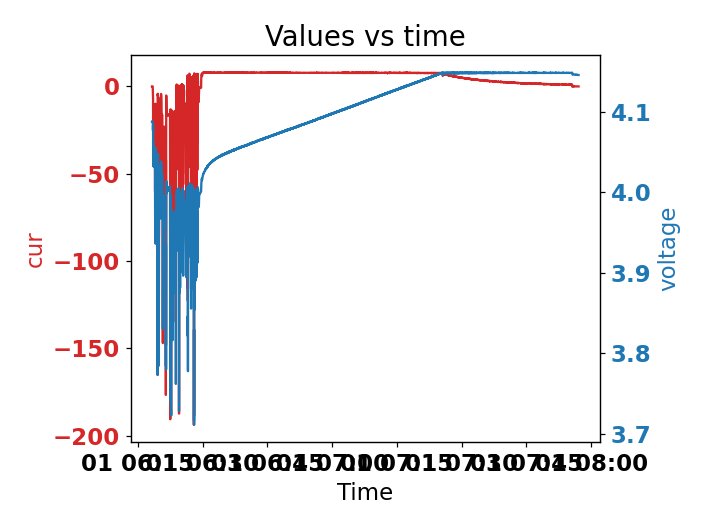

<IPython.core.display.Javascript object>


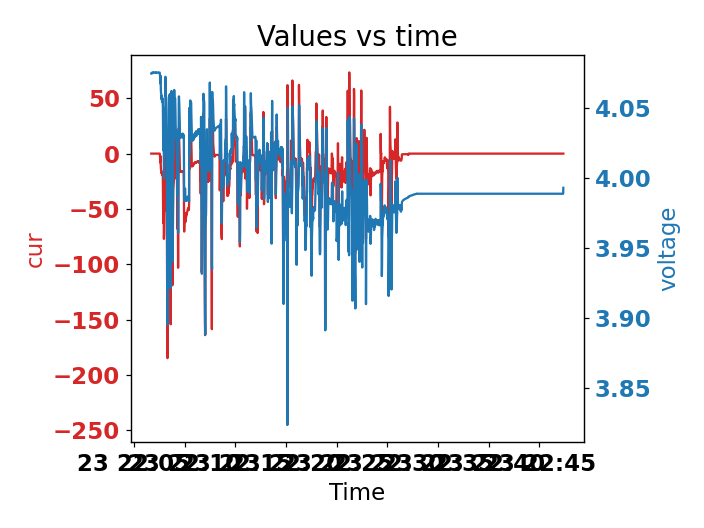

In [14]:
%matplotlib notebook
# Randomly plot some ts from battery cells
import random

# Take randomly 10 dfs from list and plot them
random.seed(0)           # seed for regenerating, any number for seed
li_random_cycles = random.sample(range(len(li_ts_cycles)), 4)    # randomly pick 4 battery cells

print(li_random_cycles)
for x in li_random_cycles:
    df_temp = li_ts_cycles[x].copy()
    custom_plot.plot_dual_axis((df_temp['timestamp'], "Time"), (df_temp['current'], "cur"), (df_temp['V'], "voltage"))
#     custom_plot.plot_xy((df_temp['timestamp'], constants.x_label_datetime), (df_temp['current'], "current"))
    

In [15]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen
df_temp = li_ts_cycles[li_random_cycles[0]].copy()
df_temp = df_temp.drop(['timestamp'], axis=1)
coint_johansen(df_temp,-1,1).eig


LinAlgError: Singular matrix

In [18]:
li_V1 = []
for df_x in li_ts_cycles:    
    # Take one cell data to avoid time overlap
    if 'V1' in df_x:
        li_V1.append(df_x)

In [20]:
li_V60 = []
for df_x in li_ts_cycles:    
    # Take one cell data to avoid time overlap
    if 'V60' in df_x:
        li_V60.append(df_x)

<IPython.core.display.Javascript object>


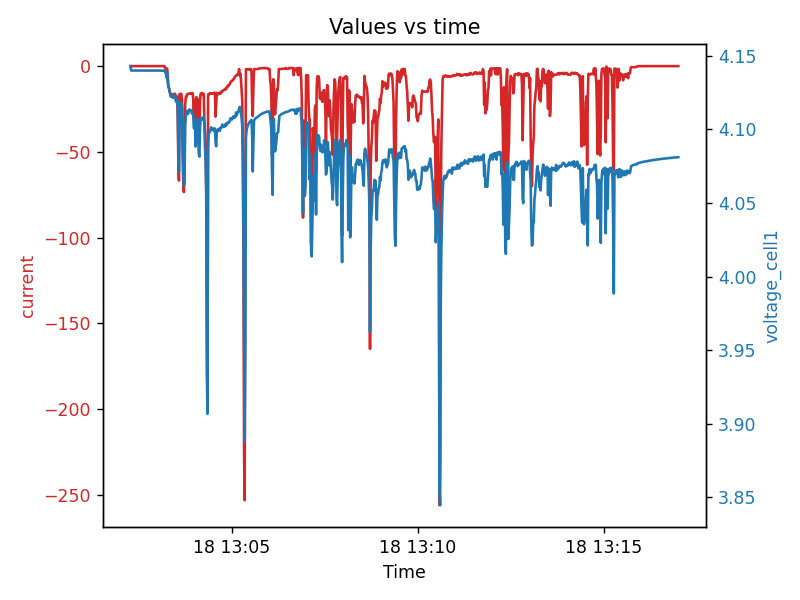

PermissionError: [Errno 13] Permission denied: 'my_figure.eps'

In [25]:
%matplotlib notebook

for df_each in li_V1:
    df_temp = df_each.copy()
#     plot_xy((df_temp['elapsed_sec'], "Time (s)"), (df_temp['V1'], "V1"))
    custom_plot.plot_dual_axis((df_temp['timestamp'], "Time"), (df_temp['current'], "current"), (df_temp['V1'], "voltage_cell1"))
    df_temp = np.nan


In [26]:
print(li_V1[0])

                  timestamp      V1  current  Temp_mean_module1
1096325 2022-01-18 13:02:17  4.1430      0.0               12.0
1096326 2022-01-18 13:02:18  4.1400      0.0               13.0
965787  2022-01-18 13:02:19  4.1400      0.0               13.0
965788  2022-01-18 13:02:20  4.1400      0.0               13.0
965789  2022-01-18 13:02:21  4.1400      0.0               13.0
...                     ...     ...      ...                ...
966664  2022-01-18 13:16:56  4.0810      0.0               13.0
966665  2022-01-18 13:16:57  4.0810      0.0               13.0
1097206 2022-01-18 13:16:58  4.0810      0.0               13.0
1097207 2022-01-18 13:16:59  4.0811      0.0               13.0
1097208 2022-01-18 13:17:00  4.0811      0.0               13.0

[884 rows x 4 columns]


In [27]:
df_connected_V1 = pd.concat(li_V1)
df_connected_V1['timestamp'].is_monotonic_increasing

True

In [32]:
df_connected_V1["time_idx"] = df_connected_V1['timestamp'].dt.second

In [1]:
print(df_connected_V1)

NameError: name 'df_connected_V1' is not defined